In [1]:
import numpy as np
import sys
from scipy.interpolate import interp1d
sys.path.append('..')
from dcc import Parameters, AAV
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from learning.collections_env import CollectionsEnv
from learning.utils import DiscretizedActionWrapper

p = Parameters()

In [2]:
actions_bins = np.array([0, 1.0])
c_env = CollectionsEnv(params=p, reward_shaping='discrete', randomize_start=False, max_lambda=None, starting_state=np.array([0.11, 1], dtype=np.float32))
environment = DiscretizedActionWrapper(c_env, actions_bins)

New action space: Discrete(2)


c:\users\markm\.conda\envs\tf2-gpu\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [51]:
import joblib

class DiscretePolicyConstructor:
    
    def __init__(self, env ,mc_n):
        self.env = env
        self.n_actions = environment.action_space.n
        self.mc_n = mc_n
        n_pts_w = int(200)
        n_pts_l = int(50)
        MAX_L = 7.0
        self.w_grid = np.linspace(0, self.env.w0, n_pts_w)
        self.l_grid = np.linspace(self.env.params.lambdainf, MAX_L, n_pts_l)
        self.ww, self.ll = np.meshgrid(self.w_grid, self.l_grid)
        self.policy = np.zeros_like(self.ww, dtype=np.int32)
        
    def reconstruct_policy(self):
        self.policy = interp1d(self.grid, self.lhats) 
    
    def get_action(self, state):
        bal = state[1]
        lam = state[0]
        i = np.digitize(bal, self.w_grid, right=True)
        j = np.digitize(lam, self.l_grid, right=True)
        return self.policy[j, i]
    
    def evaluate(self, start_state, first_action):
        self.env.reset(tostate=start_state)
        done = False
        score = 0

        next_state, reward, done, info = self.env.step(first_action)
        score += reward
        state = next_state.copy()
        
        while not done:
            action = self.get_action(state)
            next_state, reward, done, info = self.env.step(action)
            score += reward
            state = next_state.copy()      
        return score
    
    def parallel_evaluate(self, state, first_ac, mc):
        res = joblib.Parallel(n_jobs=6)(joblib.delayed(self.evaluate)(state, first_ac) for i in range(mc))
        return np.mean(res) 
    
    def run(self):
        action_estimates = np.zeros(self.n_actions)
        i = 0
        for j, w in enumerate(self.w_grid):
            print(f'Balance: {w}')
            flag_searching = True
            while flag_searching:
                l = self.l_grid[i]
                state = np.array([l, w])
                for a_index in range(self.n_actions):
                    action_estimates[a_index] = self.parallel_evaluate(state, a_index, self.mc_n)
                
                best_action = np.argmax(action_estimates)
                
                if best_action == 0:
                    flag_searching = False
                else:
                    self.policy[i , j:] = best_action
                    i += 1
                    print(i)

In [52]:
agent = DiscretePolicyConstructor(environment, 500)

In [53]:
agent.run()

Balance: 0.0
Balance: 1.0050251256281406
Balance: 2.0100502512562812
Balance: 3.015075376884422
Balance: 4.0201005025125625
Balance: 5.025125628140703
Balance: 6.030150753768844
Balance: 7.035175879396984
Balance: 8.040201005025125
Balance: 9.045226130653266
Balance: 10.050251256281406
Balance: 11.055276381909547
Balance: 12.060301507537687
Balance: 13.065326633165828
Balance: 14.070351758793969
Balance: 15.07537688442211
Balance: 16.08040201005025
Balance: 17.08542713567839
Balance: 18.09045226130653
Balance: 19.09547738693467
Balance: 20.100502512562812
Balance: 21.105527638190953
Balance: 22.110552763819094
Balance: 23.115577889447234
Balance: 24.120603015075375
Balance: 25.125628140703515
Balance: 26.130653266331656
Balance: 27.135678391959797
Balance: 28.140703517587937
Balance: 29.145728643216078
Balance: 30.15075376884422
Balance: 31.15577889447236
Balance: 32.1608040201005
Balance: 33.16582914572864
Balance: 34.17085427135678
Balance: 35.175879396984925
Balance: 36.180904522613

In [56]:
agent.policy.shape

(50, 200)

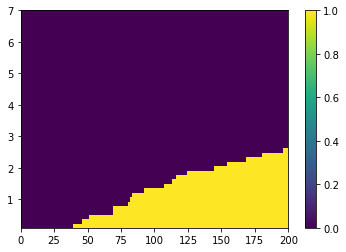

In [57]:
plt.pcolor(agent.ww, agent.ll, agent.policy)
plt.colorbar()
plt.show()

In [45]:
agent.get_action(np.array([1.0, 0.0]))

0

In [ ]:
rew_list = []
for i in range(500):
    rew_list.append(agent.evaluate(np.array([0.11, 100.0]), 0))

In [ ]:
np.mean(rew_list)

In [ ]:
res = agent.parallel_evaluate(500)

In [ ]:
plt.plot(res)

In [ ]:
import seaborn as sns
sns.distplot(res)

In [ ]:
agent.get_action(np.array([2, 100]))
agent.env.action_bins

In [ ]:
agent.policy.shape

In [ ]:
np.digitize(100, agent.w_grid)

In [ ]:
w_grid = np.linspace(1, 200, 20)
l_grid = np.linspace(0, 7, 20)
a_grid = np.linspace(0, 1, 2)
ww, ll = np.meshgrid(w_grid, l_grid)

In [ ]:
grid

In [ ]:
environment.step(1)

In [ ]:
discretized_grid = np.linspace(1, environment.w0, 200)
short_grid = np.linspace(1, environment.w0, 15)
def lin(x):
    return np.sin(x * 0.03)

lams = lin(short_grid)
full_lams = lin(discretized_grid)

In [ ]:
 interp = interp1d(short_grid, lams)

In [ ]:
plt.plot(discretized_grid, full_lams)
plt.plot(short_grid, lams, marker='o')